In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

In [21]:
'''This notebook takes the cleaned future Caltrain timetables output from Future_schedule_cleaning.ipynb,
processes them to hourly summaries, and exports to CSV'''

'This notebook takes the cleaned future Caltrain timetables output from Future_schedule_cleaning.ipynb,\nprocesses them to hourly summaries, and exports to CSV'

In [22]:
df = pd.read_csv('../data/parsed_data/schedules/future_schedules_cleaned.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15928 entries, 0 to 15927
Data columns (total 7 columns):
km          15928 non-null int64
station     15928 non-null object
train_id    15928 non-null object
time        15928 non-null int64
hr          15928 non-null int64
min         15928 non-null int64
scenario    15928 non-null object
dtypes: int64(4), object(3)
memory usage: 871.1+ KB


In [24]:
df.head()

,km,station,train_id,time,hr,min,scenario
0,78,SAN JOSE,IC (HSR) 701_single_1,348,5,48,Baseline SB
1,126,GILROY (HSR) $,IC (HSR) 701_single_1,373,6,13,Baseline SB
2,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB
3,24,MILLBRAE,HSR 801_single_2,330,5,30,Baseline SB
4,78,SAN JOSE,HSR 801_single_2,365,6,5,Baseline SB


In [25]:
def get_station_pairs(df):
    
    df = df.copy()
    
    #Get departure and arrival stop info
    df_stops_arr = df.copy()
    df = df.rename(columns={"station": "departure_station",
                                        "time": "departure_time",
                                        "hr": "departure_hour",
                                        "min": "departure_minute",
                                        "km": "departure_km"})
    
    df_stops_arr = df_stops_arr.rename(columns={"station": "arrival_station",
                                        "time": "arrival_time",
                                        "hr": "arrival_hour",
                                        "min": "arrival_minute",
                                        "km": "arrival_km"})

    #Join the two on train ID and scenario
    df = df.merge(df_stops_arr, on=['scenario', 'train_id'])

    #Thow out any journeys that do not go forwards in time
    df = df[df['arrival_time'] >= df['departure_time']]

    #Add trip duration column
    df['trip_duration'] = df['arrival_time'] - df['departure_time']
    
    #Add trip distance column
    df['trip_length'] = df['arrival_km'] - df['departure_km']
    
    df = df.reset_index(drop=True)

    return df

df_pairs = get_station_pairs(df)

In [26]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132922 entries, 0 to 132921
Data columns (total 14 columns):
departure_km         132922 non-null int64
departure_station    132922 non-null object
train_id             132922 non-null object
departure_time       132922 non-null int64
departure_hour       132922 non-null int64
departure_minute     132922 non-null int64
scenario             132922 non-null object
arrival_km           132922 non-null int64
arrival_station      132922 non-null object
arrival_time         132922 non-null int64
arrival_hour         132922 non-null int64
arrival_minute       132922 non-null int64
trip_duration        132922 non-null int64
trip_length          132922 non-null int64
dtypes: int64(10), object(4)
memory usage: 14.2+ MB


In [27]:
df_pairs.head()

,departure_km,departure_station,train_id,departure_time,departure_hour,departure_minute,scenario,arrival_km,arrival_station,arrival_time,arrival_hour,arrival_minute,trip_duration,trip_length
0,78,SAN JOSE,IC (HSR) 701_single_1,348,5,48,Baseline SB,78,SAN JOSE,348,5,48,0,0
1,78,SAN JOSE,IC (HSR) 701_single_1,348,5,48,Baseline SB,126,GILROY (HSR) $,373,6,13,25,48
2,126,GILROY (HSR) $,IC (HSR) 701_single_1,373,6,13,Baseline SB,126,GILROY (HSR) $,373,6,13,0,0
3,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB,0,SALESFORCE TRANSIT CENTER (STC) $,310,5,10,0,0
4,0,SALESFORCE TRANSIT CENTER (STC) $,HSR 801_single_2,310,5,10,Baseline SB,24,MILLBRAE,330,5,30,20,24


In [28]:
df_journey_times = df_pairs.groupby(['scenario', 'departure_station', 'arrival_station', 'departure_hour'])\
    .agg(['count', 'mean', 'min', 'max'])['trip_duration']\
    .reset_index()

In [29]:
df_journey_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41612 entries, 0 to 41611
Data columns (total 8 columns):
scenario             41612 non-null object
departure_station    41612 non-null object
arrival_station      41612 non-null object
departure_hour       41612 non-null int64
count                41612 non-null int64
mean                 41612 non-null float64
min                  41612 non-null int64
max                  41612 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.5+ MB


In [30]:
df_journey_times.head()

,scenario,departure_station,arrival_station,departure_hour,count,mean,min,max
0,Baseline NB,22nd STREET,22nd STREET,6,3,0.0,0,0
1,Baseline NB,22nd STREET,22nd STREET,7,4,0.0,0,0
2,Baseline NB,22nd STREET,22nd STREET,8,4,0.0,0,0
3,Baseline NB,22nd STREET,22nd STREET,9,4,0.0,0,0
4,Baseline NB,22nd STREET,22nd STREET,10,4,0.0,0,0


In [31]:
def cartesian_product( lsts ):
    """
    Returns Pandas DataFrame containing cartesian product of lists. This is the
    same as itertools.product, but faster.
    """

    ret = None

    for lst in lsts:
        subtable = pd.DataFrame(lst)
        subtable["key"] = 1

        if ret is None:
            ret = subtable
        else:
            ret = ret.merge(subtable, on="key")

    # they 'key' column was just a trick to get a set product; it's no longer needed
    ret = ret.drop("key", axis=1)

    return ret

In [32]:
def get_wait_times(df, verbose=True):
    """
    Finds parameter estimates for the distribution of travel times for all
    sets of (start_time, route_name, origin_stop, destination_stop) present in
    the input dataframe.
    Args:
        df (DataFrame): DataFrame in format returned by `stops_to_durations`.
    Returns:
        (DataFrame): Contains distribution parameters of fit beta
        distribution for all (start_time, route_name, origin_stop,
        destination_stop) present in `df`.
    """
    
    df = df.copy()

    # we'll construct a dataframe with those unique combinations of origin
    # stop, destination stop, and departure time
    if verbose: print( "finding all time slices..." )
    df_timestamps = cartesian_product( [df['scenario'].unique(),
                                        df['departure_station'].unique(),
                                        df['arrival_station'].unique(),
                                        df['departure_hour'].unique(),
                                        np.arange(0,60)] )
    df_timestamps.columns = ["scenario", "departure_station", "arrival_station", "passenger_at_station_hour", "passenger_at_station_minute"]
    # the `departure_hour` and `minute` columns are a means towards
    # a `passenger_at_station_time` column
    df_timestamps['passenger_at_station_time'] = df_timestamps['passenger_at_station_hour']*60 + df_timestamps['passenger_at_station_minute']

    # Get every depart/arrival/time combination and sort them so that
    # depart+arrive are adjacent and in chronological order. Then, take
    # the observed journey times, and fill in corresponding time/block rows.
    if verbose: print( "merging with observed journeys...")
    df_timestamps = df_timestamps.sort_values(['scenario', 'departure_station', 'arrival_station', 'passenger_at_station_time'])
    df_timestamps = df_timestamps.reset_index(drop=True)
    
    #We need to merge passenger_at_station_time onto departure_time,
    #but we also need to preserve departure_time, so make a copy of it
    df['passenger_at_station_time'] = df['departure_time']

    df = df_timestamps.merge(df, on=['scenario', 'passenger_at_station_time', 'departure_station', 'arrival_station'], how='left')
    
    # Backfill so each minute has the data for the next departure. Thus each
    # row contains a minute of the day, the next arrival, and the journey time
    # for that trip.
    if verbose: print( "backfilling time slices with next journey..." )
    df = df.groupby(['scenario', 'departure_station', 'arrival_station']).apply(lambda group: group.fillna(method='bfill'))

    #Add journey time columns
    df['wait_time'] = df['departure_time'] - df['passenger_at_station_time']

    
    #Drop NaNs (occurs at the end of the data set when we don't know when the next train will come.)
    df = df.dropna(subset=['wait_time'])
    
    if verbose: print( "calculating aggregates..." )
    #Group to get results by scenario, station pair, and passenger arrival hour
    df = df.groupby(['scenario', 'departure_station', 'arrival_station', 'passenger_at_station_hour'])\
        .agg(['count', 'mean', 'min', 'max'])['wait_time']\
        .reset_index()
    
    #Rename 'passenger_at_station_hour' for consistancy with other dataframes
    df.rename(columns={'passenger_at_station_hour': 'departure_hour'}, inplace=True)
    
    return df
df_wait_times = get_wait_times(df_pairs)

finding all time slices...
merging with observed journeys...
backfilling time slices with next journey...
calculating aggregates...


In [33]:
df_wait_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45362 entries, 0 to 45361
Data columns (total 8 columns):
scenario             45362 non-null object
departure_station    45362 non-null object
arrival_station      45362 non-null object
departure_hour       45362 non-null int64
count                45362 non-null int64
mean                 45362 non-null float64
min                  45362 non-null float64
max                  45362 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.8+ MB


In [34]:
df_wait_times.head()

,scenario,departure_station,arrival_station,departure_hour,count,mean,min,max
0,Baseline NB,22nd STREET,22nd STREET,4,60,115.5,86.0,145.0
1,Baseline NB,22nd STREET,22nd STREET,5,60,55.5,26.0,85.0
2,Baseline NB,22nd STREET,22nd STREET,6,60,10.5,0.0,25.0
3,Baseline NB,22nd STREET,22nd STREET,7,60,9.7,0.0,23.0
4,Baseline NB,22nd STREET,22nd STREET,8,60,9.7,0.0,23.0


In [35]:
#Finally, merge journey times and wait times together
df_final = df_journey_times.merge(df_wait_times,
                       on=['scenario', 'departure_station', 'arrival_station', 'departure_hour'],
                       suffixes=['_journey_time', '_wait_time'])

In [36]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41612 entries, 0 to 41611
Data columns (total 12 columns):
scenario              41612 non-null object
departure_station     41612 non-null object
arrival_station       41612 non-null object
departure_hour        41612 non-null int64
count_journey_time    41612 non-null int64
mean_journey_time     41612 non-null float64
min_journey_time      41612 non-null int64
max_journey_time      41612 non-null int64
count_wait_time       41612 non-null int64
mean_wait_time        41612 non-null float64
min_wait_time         41612 non-null float64
max_wait_time         41612 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 4.1+ MB


In [37]:
df_final.head()

,scenario,departure_station,arrival_station,departure_hour,count_journey_time,mean_journey_time,min_journey_time,max_journey_time,count_wait_time,mean_wait_time,min_wait_time,max_wait_time
0,Baseline NB,22nd STREET,22nd STREET,6,3,0.0,0,0,60,10.5,0.0,25.0
1,Baseline NB,22nd STREET,22nd STREET,7,4,0.0,0,0,60,9.7,0.0,23.0
2,Baseline NB,22nd STREET,22nd STREET,8,4,0.0,0,0,60,9.7,0.0,23.0
3,Baseline NB,22nd STREET,22nd STREET,9,4,0.0,0,0,60,9.7,0.0,23.0
4,Baseline NB,22nd STREET,22nd STREET,10,4,0.0,0,0,60,9.7,0.0,23.0


In [38]:
df_final.groupby(['scenario']).count()

,departure_station,arrival_station,departure_hour,count_journey_time,mean_journey_time,min_journey_time,max_journey_time,count_wait_time,mean_wait_time,min_wait_time,max_wait_time
scenario,,,,,,,,,,,
Baseline NB,5599,5599,5599,5599,5599,5599,5599,5599,5599,5599,5599
Baseline SB,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647
HIgh NB,7857,7857,7857,7857,7857,7857,7857,7857,7857,7857,7857
High SB,7906,7906,7906,7906,7906,7906,7906,7906,7906,7906,7906
Moderate NB,6987,6987,6987,6987,6987,6987,6987,6987,6987,6987,6987
Moderate SB,7616,7616,7616,7616,7616,7616,7616,7616,7616,7616,7616


In [39]:
df_final.to_csv('../data/parsed_data/schedules/future_schedules_metrics.csv', index=False)

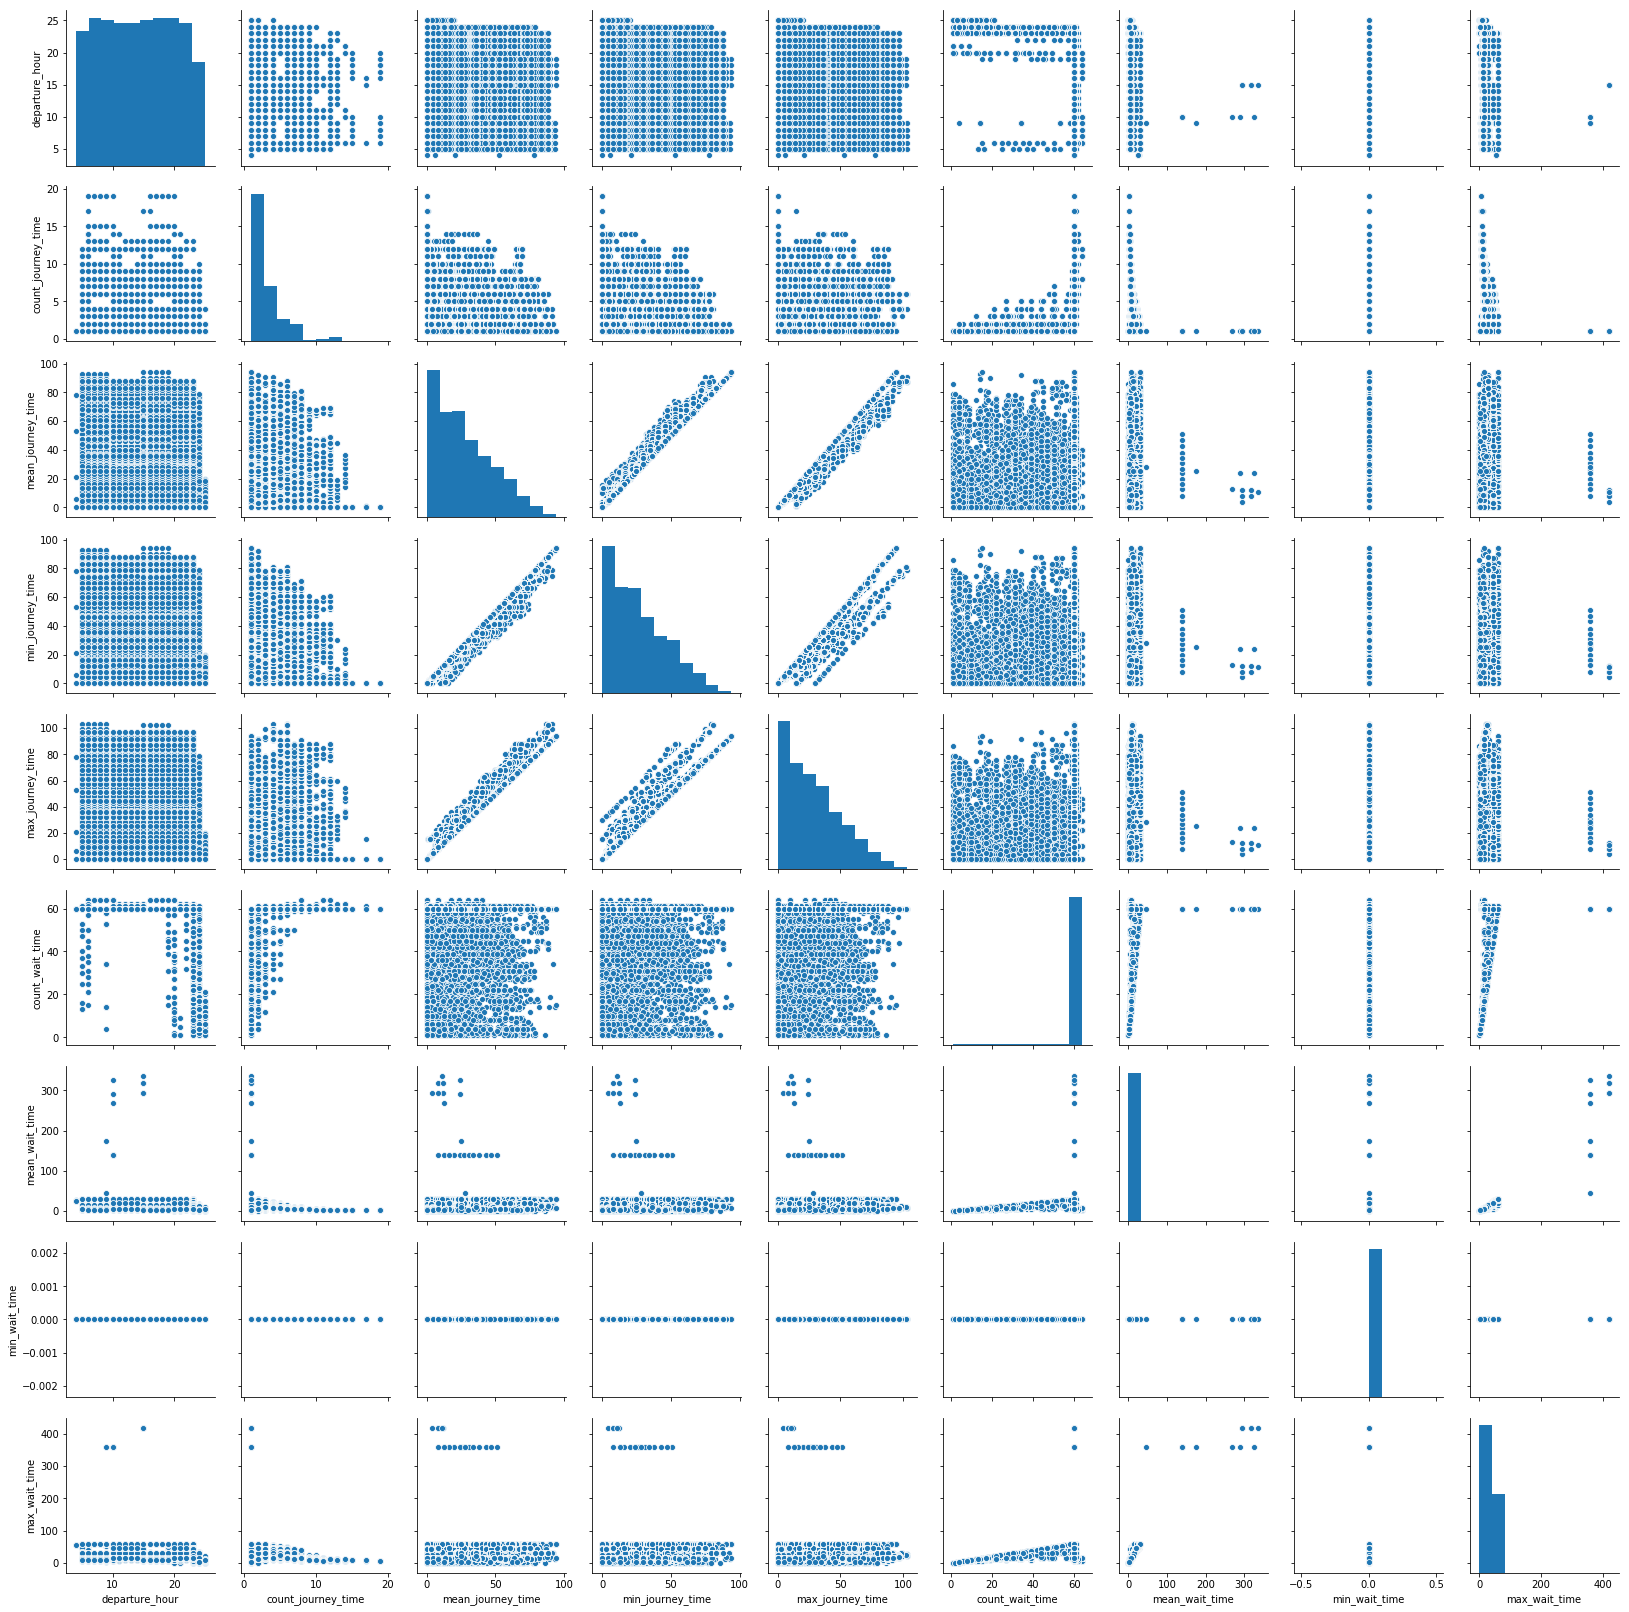

In [40]:
sns.pairplot(df_final)

In [41]:
'''
Hour
origin_id
origin_name
dest_id
scenario
Min Wait at Origin Station
Average Wait at Origin Station
Max Wait at Origin Station
Min Length of Journey
Average Length of Journey
Max Length of Journey
CO2 Emissions
Ridership Number
'''

'\nHour\norigin_id\norigin_name\ndest_id\nscenario\nMin Wait at Origin Station\nAverage Wait at Origin Station\nMax Wait at Origin Station\nMin Length of Journey\nAverage Length of Journey\nMax Length of Journey\nCO2 Emissions\nRidership Number\n'